In [20]:
import tweepy
import pandas as pd

In [21]:
# API Key setup
api_key = 'XLrT4TY4C8ZdIFQOMri1QX6Cc'
api_secret_key = 'nFdnp9YT30Omojj9JZdtqD6j6qKP6vvuo65FjLOt6Fe0eotwpZ'
access_token = '3083368926-c7fXpsH0k1Hrqs6bNe7954RMMp7viwgK7paRuHX'
access_token_secret = 'bTTr0tiF4Xizcnjj7gGS1efzhSN5Co8Cgcc0P1cHjMXeF'
# Bearer token from Twitter API v2
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJttvwEAAAAAve3ZMFPG3IVh5poNuakDQUxLo%2Fw%3DcdUn78VL26nE15hTVzu9hjKEl1raNd8xRnvL00uVVloJABXMSD'

In [22]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [23]:
import tweepy
import logging

# Create client for Twitter API v2
client = tweepy.Client(bearer_token=bearer_token)

# Query tweets using the v2 API
query = 'attrition risk OR employee turnover OR workplace stress OR HR issues lang:en'
response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=100)

# Store tweet details in a DataFrame
tweet_data = []
for tweet in response.data:
    tweet_data.append([tweet.created_at, tweet.author_id, tweet.text])

df_tweets = pd.DataFrame(tweet_data, columns=['Timestamp', 'Author_ID', 'Tweet'])

# Display first few rows
print(df_tweets.head())


                  Timestamp            Author_ID  \
0 2024-09-23 00:11:39+00:00  1568308869528715264   
1 2024-09-22 23:38:25+00:00           2359978896   
2 2024-09-22 23:27:43+00:00  1804359690257653760   
3 2024-09-22 23:27:27+00:00  1804359690257653760   
4 2024-09-22 23:27:07+00:00  1804359690257653760   

                                               Tweet  
0  RT @aiboc_in: 5-Day Work Week: A Standard for ...  
1  RT @aiboc_in: 5-Day Work Week: A Standard for ...  
2  @EQUANS_UK @WarringtonBC I am an ex employee o...  
3  I am an ex employee of @EQUANS_UK, who are own...  
4  @EQUANS_UK I am an ex employee of @EQUANS_UK, ...  


In [24]:
import re

def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)        # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    return text.strip().lower()

df_tweets['Cleaned_Tweet'] = df_tweets['Tweet'].apply(clean_tweet)
print(df_tweets[['Tweet', 'Cleaned_Tweet']].head())


                                               Tweet  \
0  RT @aiboc_in: 5-Day Work Week: A Standard for ...   
1  RT @aiboc_in: 5-Day Work Week: A Standard for ...   
2  @EQUANS_UK @WarringtonBC I am an ex employee o...   
3  I am an ex employee of @EQUANS_UK, who are own...   
4  @EQUANS_UK I am an ex employee of @EQUANS_UK, ...   

                                       Cleaned_Tweet  
0  rt  day work week a standard for productivity ...  
1  rt  day work week a standard for productivity ...  
2  i am an ex employee of  who are owned by    un...  
3  i am an ex employee of  who are owned by    un...  
4  i am an ex employee of  who are owned by    un...  


In [25]:
from transformers import pipeline

# Load sentiment-analysis pipeline
sentiment_model = pipeline('sentiment-analysis')

# Apply sentiment analysis
df_tweets['Sentiment'] = df_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])

print(df_tweets[['Cleaned_Tweet', 'Sentiment']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


                                       Cleaned_Tweet Sentiment
0  rt  day work week a standard for productivity ...  POSITIVE
1  rt  day work week a standard for productivity ...  POSITIVE
2  i am an ex employee of  who are owned by    un...  NEGATIVE
3  i am an ex employee of  who are owned by    un...  NEGATIVE
4  i am an ex employee of  who are owned by    un...  NEGATIVE


/var/folders/s8/3_8sqyx15p5fjp2tv272n1580000gn/T/ipykernel_4444/472202984.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


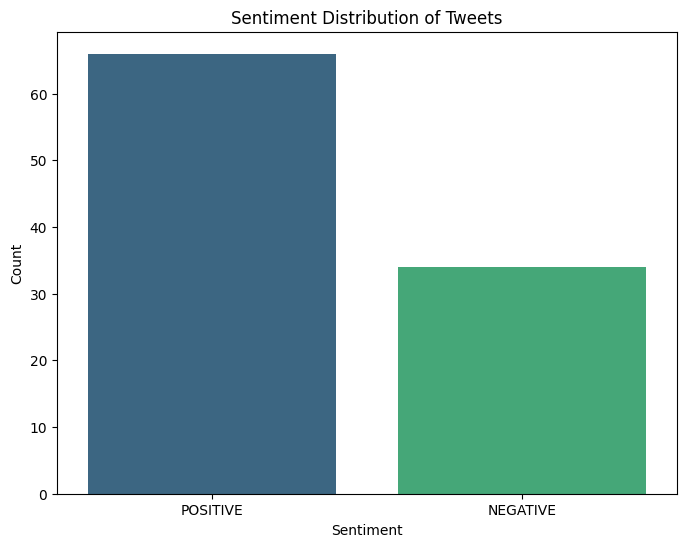

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the sentiment occurrences
sentiment_counts = df_tweets['Sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Tweets')
plt.show()


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df_tweets['Cleaned_Tweet'])

# Convert to DataFrame
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming you have labels for training
y = df_tweets['Sentiment'] 

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    NEGATIVE       0.77      1.00      0.87        10
    POSITIVE       1.00      0.85      0.92        20

    accuracy                           0.90        30
   macro avg       0.88      0.93      0.89        30
weighted avg       0.92      0.90      0.90        30



In [29]:
import time
import logging
import pandas as pd

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

def process_tweets():
    tweet_count = 0
    max_tweets = 5
    
    while tweet_count < max_tweets:
        start_time = time.time()
        
        try:
            # Fetch new tweets
            fetch_start = time.time()
            response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=10)
            if response.data is None:
                logger.warning("No tweets found.")
                time.sleep(60)  # Sleep and retry if no tweets
                continue
            fetch_time = time.time() - fetch_start
            
            # Process and clean tweets
            process_start = time.time()
            new_tweets = pd.DataFrame([[tweet.created_at, tweet.author_id, tweet.text] for tweet in response.data], columns=['Timestamp', 'Author_ID', 'Tweet'])
            new_tweets['Cleaned_Tweet'] = new_tweets['Tweet'].apply(clean_tweet)
            process_time = time.time() - process_start
            
            # Extract features
            feature_start = time.time()
            new_features = vectorizer.transform(new_tweets['Cleaned_Tweet'])
            df_new_features = pd.DataFrame(new_features.toarray(), columns=vectorizer.get_feature_names_out())
            feature_time = time.time() - feature_start
            
            # Predict attrition risk
            predict_start = time.time()
            predictions = model.predict(df_new_features)
            predict_time = time.time() - predict_start
            
            # Output predictions and increment tweet_count
            for tweet, prediction in zip(new_tweets['Tweet'], predictions):
                if tweet_count < max_tweets:
                    print(f"Tweet: {tweet}\nPrediction: {prediction}\n")
                    tweet_count += 1
                else:
                    break
            
            # Log times
            logger.info(f"Fetch time: {fetch_time:.2f} seconds")
            logger.info(f"Process time: {process_time:.2f} seconds")
            logger.info(f"Feature extraction time: {feature_time:.2f} seconds")
            logger.info(f"Prediction time: {predict_time:.2f} seconds")
        
        except Exception as e:
            logger.error(f"An error occurred: {e}")
            break
        
        if tweet_count < max_tweets:
            # Sleep for a while before fetching new tweets
            time.sleep(60)  # Fetch new tweets every 1 minute
    
    print("Processed 5 tweets. Exiting...")

# Run the real-time processing function
process_tweets()


INFO:root:Fetch time: 0.17 seconds
INFO:root:Process time: 0.00 seconds
INFO:root:Feature extraction time: 0.00 seconds
INFO:root:Prediction time: 0.00 seconds


Tweet: RT @aiboc_in: 5-Day Work Week: A Standard for Productivity, Growth &amp; Efficiency and a norm for ethical workplace.

Across sectors globally,…
Prediction: POSITIVE

Tweet: RT @aiboc_in: 5-Day Work Week: A Standard for Productivity, Growth &amp; Efficiency and a norm for ethical workplace.

Across sectors globally,…
Prediction: POSITIVE

Tweet: @EQUANS_UK @WarringtonBC I am an ex employee of @EQUANS_UK, who are owned by @GroupeBouygues, @MartinBouygues. @EQUANS_UK unlawfully dismissed my Workplace Stress Risk Assessment. A criminal act. UK Health &amp; Safety Law. It is still unresolved, unaddressed, unaccounted for. Owners @GroupeBouygues care not
Prediction: NEGATIVE

Tweet: I am an ex employee of @EQUANS_UK, who are owned by @GroupeBouygues, @MartinBouygues. @EQUANS_UK unlawfully dismissed my Workplace Stress Risk Assessment. A criminal act. UK Health &amp; Safety Law. It is still unresolved, unaddressed, unaccounted for. Owners @GroupeBouygues care not https://t.co/JuhTsugm

### Applying LLM --> GPT2

In [30]:
from transformers import pipeline

# Initialize the sentiment-analysis pipeline
sentiment_model = pipeline('sentiment-analysis')


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [31]:
# Apply sentiment analysis using the LLM
df_tweets['LLM_Sentiment'] = df_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])

print(df_tweets[['Cleaned_Tweet', 'LLM_Sentiment']].head())


                                       Cleaned_Tweet LLM_Sentiment
0  rt  day work week a standard for productivity ...      POSITIVE
1  rt  day work week a standard for productivity ...      POSITIVE
2  i am an ex employee of  who are owned by    un...      NEGATIVE
3  i am an ex employee of  who are owned by    un...      NEGATIVE
4  i am an ex employee of  who are owned by    un...      NEGATIVE


In [32]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Initialize GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [33]:
def generate_topics(text, max_input_length=50, max_new_tokens=20):
    # Truncate the input text if it's longer than the max_input_length
    inputs = tokenizer.encode(text[:max_input_length], return_tensors='pt')
    
    # Generate topics with a set number of new tokens
    outputs = model.generate(inputs, max_new_tokens=max_new_tokens, num_return_sequences=1)
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Apply topic generation to the cleaned tweets
df_tweets['Generated_Topics'] = df_tweets['Cleaned_Tweet'].apply(generate_topics)

# Display the results
print(df_tweets[['Cleaned_Tweet', 'Generated_Topics']].head())


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

                                       Cleaned_Tweet  \
0  rt  day work week a standard for productivity ...   
1  rt  day work week a standard for productivity ...   
2  i am an ex employee of  who are owned by    un...   
3  i am an ex employee of  who are owned by    un...   
4  i am an ex employee of  who are owned by    un...   

                                    Generated_Topics  
0  rt  day work week a standard for productivity ...  
1  rt  day work week a standard for productivity ...  
2  i am an ex employee of  who are owned by    un...  
3  i am an ex employee of  who are owned by    un...  
4  i am an ex employee of  who are owned by    un...  


In [34]:
def process_tweets_with_llm():
    tweet_count = 0  # Counter for the number of tweets processed
    
    while tweet_count < 5:  # Loop until 5 tweets are processed
        # Fetch new tweets
        response = client.search_recent_tweets(query=query, tweet_fields=['created_at', 'author_id', 'text'], max_results=10)
        
        # Process and clean tweets
        new_tweets = pd.DataFrame([[tweet.created_at, tweet.author_id, tweet.text] for tweet in response.data], columns=['Timestamp', 'Author_ID', 'Tweet'])
        new_tweets['Cleaned_Tweet'] = new_tweets['Tweet'].apply(clean_tweet)
        
        # Apply LLM sentiment analysis
        new_tweets['LLM_Sentiment'] = new_tweets['Cleaned_Tweet'].apply(lambda tweet: sentiment_model(tweet)[0]['label'])
        
        # Output results
        for tweet, sentiment in zip(new_tweets['Tweet'], new_tweets['LLM_Sentiment']):
            print(f"Tweet: {tweet}\nLLM Sentiment: {sentiment}\n")
            tweet_count += 1
            if tweet_count >= 5:
                break
        
        # If 5 tweets have been printed, exit the loop
        if tweet_count >= 5:
            break

# Run the real-time processing function with LLM
process_tweets_with_llm()

Tweet: RT @aiboc_in: 5-Day Work Week: A Standard for Productivity, Growth &amp; Efficiency and a norm for ethical workplace.

Across sectors globally,…
LLM Sentiment: POSITIVE

Tweet: RT @aiboc_in: 5-Day Work Week: A Standard for Productivity, Growth &amp; Efficiency and a norm for ethical workplace.

Across sectors globally,…
LLM Sentiment: POSITIVE

Tweet: @EQUANS_UK @WarringtonBC I am an ex employee of @EQUANS_UK, who are owned by @GroupeBouygues, @MartinBouygues. @EQUANS_UK unlawfully dismissed my Workplace Stress Risk Assessment. A criminal act. UK Health &amp; Safety Law. It is still unresolved, unaddressed, unaccounted for. Owners @GroupeBouygues care not
LLM Sentiment: NEGATIVE

Tweet: I am an ex employee of @EQUANS_UK, who are owned by @GroupeBouygues, @MartinBouygues. @EQUANS_UK unlawfully dismissed my Workplace Stress Risk Assessment. A criminal act. UK Health &amp; Safety Law. It is still unresolved, unaddressed, unaccounted for. Owners @GroupeBouygues care not https://t.co

In [35]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

# Define test paths
test_tokenizer_path = r'C:\temp\tokenizer'
test_model_path = r'C:\temp\model'

# Create test directories
os.makedirs(test_tokenizer_path, exist_ok=True)
os.makedirs(test_model_path, exist_ok=True)

# Save the tokenizer and model to the test directories
tokenizer.save_pretrained(test_tokenizer_path)
model.save_pretrained(test_model_path)
